# RAPL Energy Consumption

In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from pathlib import Path
import time
import math
from matplotlib import pyplot as plt
import subprocess
import numpy as np


**Note:** this notebook is meant to be executed on the supplied Docker image.

This notebook provides ...

## RAPL sysfs Interface

Set the `cpu_zone` as in lab 02:

In [9]:
cpu_zone = '/sys/devices/virtual/powercap/...'  # complete this path
cpu_zone = '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0'

Let's verify whether this zone seems like the zone of your CPU.

In [10]:
if os.path.isdir(cpu_zone):
    print('✓ Zone exists')
else:
    print('✗ Zone does not exist!')

name = Path(f'{cpu_zone}/name').read_text().strip()

if name.startswith('package-'):
    print('✓ Its name starts with \'package-\'')
else:
    print('✗ Its zone does not start with \'package-\'!')

if os.path.isfile(f'{cpu_zone}/energy_uj'):
    print('✓ File \'energy_uj\' exists')
else:
    print('✗ File \'energy_uj\' does not exist!')

✓ Zone exists
✓ Its name starts with 'package-'
✓ File 'energy_uj' exists


Complete the following code as in lab 02

In [11]:
def energy_uj():
    #raise exception('Not implemented')
    with open(f"{cpu_zone}/energy_uj") as energy_file:
        return int(energy_file.readline())

def max_energy():
   # return 300
   # TODO verify
   with open(f"{cpu_zone}/max_energy_range_uj") as file:
        return int(file.readline())

def energy_consumption(energy_uj_start, energy_uj_end):
    # raise exception('Not implemented')
    return energy_uj_end - energy_uj_start if energy_uj_end > energy_uj_start else max_energy() - energy_uj_start + energy_uj_end

Write a function to set long-term powercap. Keep in mind that the argument is in W, but you'll need to convert it to uW to set the powercap

In [12]:
def set_powercap(watts_limit: int):
    #raise exception('Not implemented')


    with open(f"{cpu_zone}/constraint_0_power_limit_uw", "w") as file:
        file.write(str(watts_limit * 1_000_000))
    with open(f"{cpu_zone}/constraint_1_power_limit_uw", "w") as file:
        return file.write(str(watts_limit * 1_000_000))

We're going to run a benchmark to measure the time and energy consuption for different powercap setting. We want to assess the powercap settings minimizing the time and energy consumption. It's not obvious which result is the best as we're optimizing 2 variables. To compare the results we can use a couple of different metrics which are functions of time and energy and return a single value. Each of the metrics have its own characteristics and in certain conditions for different metrics, different settings can be chosen as the best.

Note that the EDS and EDD metrics have additional $\alpha$ and $\beta$ parameters which allow for customizing the metric and define what we value more - minimizing the time or the energy.

Implement the following metrics:

1. *Energy-Delay Product (EDP)*:

   $ EDP = E \cdot t $

2. *Energy-Delay Sum (EDS)*:

   $ EDS = \alpha \cdot E + \beta \cdot t $

3. *Energy-Delay Distance (EDD)*:

   $ EDD = \sqrt{(\alpha \cdot E)^2 + (\beta \cdot t)^2} $

4. *Percentage Difference (%diff)*:

   $ \%diff = \frac{(E_{init} - E)}{E_{init}} - \frac{(t - t_{init})}{t_{init}} $

In [13]:
def edp(energy: float, time: float):
    # raise exception('Not implemented')
    return energy * time

def eds(energy: float, time: float, alpha: float, beta: float):
    # raise exception('Not implemented')
    return alpha * energy + beta * time

def edd(energy: float, time: float, alpha: float, beta: float):
    # raise exception('Not implemented')
    return math.sqrt((alpha * energy)**2 + (beta * time)**2)

def percent_diff(energy: float, time: float, init_energy: float, init_time: float):
    # raise exception('Not implemented')
    return (init_energy-energy)/init_energy - (time - init_time)/init_time
    

There are 2 simple benchmarks prepared - calculating PI with mote carlo and matrix multiplication. Implement the `benchmark_once` method to run one of the benchmarks measuring time and energy. The `pi_monte_carlo` argument should allow for choosing between the 2 benchmarks.

In [14]:
from math import sin, cos, radians

def run_monte_carlo():
    points = 100_000
    inside = 0

    for _ in range(points):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x ** 2 + y ** 2 <= 1:
            inside += 1

    pi = 4 * inside / points

def run_matrix_multiplication():
    dim = 3000
    n = np.random.rand(dim, dim)
    m = np.random.rand(dim, dim)
    return m @ n

def run_task(pi_monte_carlo: bool):
    return run_monte_carlo() if pi_monte_carlo  else run_matrix_multiplication()


def benchmark_once(pi_monte_carlo: bool, powercap_w: int, *args):
    # raise exception('Not implemented')
    # user code start

    set_powercap(powercap_w)

    time1 = time.time()
    energy1 = energy_uj()
    run_task(pi_monte_carlo)
    time2 = time.time()
    energy2 = energy_uj()


    total_time = time2 - time1
    total_energy = energy_consumption(energy1, energy2)

    return total_time, total_energy
    # user code end
    # return (time in ms, energy in uJ)

Here we have a function to run the benchmark n times, remove outlier datapoints (by time) and return average time and energy

In [15]:
def benchmark_n_times(pi_monte_carlo: bool, n: int, powercap_w: int, *args):
    responses = []

    for _ in range(n):
        responses.append(benchmark_once(pi_monte_carlo, powercap_w, *args))

    responses.sort()
    filtered = responses[int(0.25 * n): - int(0.25 * n)] # filtering outliers (by time)
    times = [x[0] for x in filtered]
    energies =  [x[1] for x in filtered]
    return np.average(times), np.average(energies)

Check your processor TDP and set variable my_tdp. Set value in W.

In [19]:
my_tdp = 65
# TODO: remove
tested_powercaps = [i for i in range(20, my_tdp + 5, 5)]

Let's run the benchmarks

In [36]:
energies = []
times = []
ntimes = 8
use_monte_carlo = False
text = 'Monte Carlo' if use_monte_carlo else 'Liczenie sin i cos'

for powercap in tested_powercaps:
    time_result, energy_result = benchmark_n_times(use_monte_carlo, ntimes, powercap)
    energies.append(energy_result)
    times.append(time_result)

Let's  plot the result energies and times for the tested powercaps

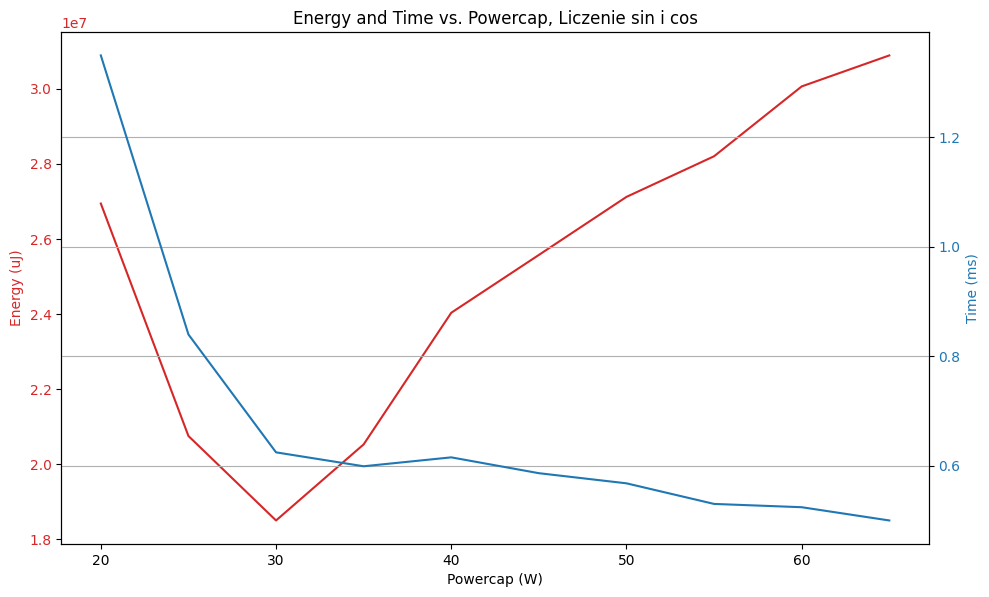

In [37]:
def plot_results_vs_powercap(tested_powercaps, times, energies):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Powercap (W)')
    ax1.set_ylabel('Energy (uJ)', color=color)
    ax1.plot(tested_powercaps, energies, color=color, label='Energy')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Time (ms)', color=color)
    ax2.plot(tested_powercaps, times, color=color, label='Time')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(f'Energy and Time vs. Powercap, {text}')
    plt.grid(True)
    plt.show()

plot_results_vs_powercap(tested_powercaps, times, energies)

We want to optimize the time and energy, but there isn't a single way to choose the optimal setting. When we have a setting that results in longer time but lower energy and another setting that results in shorter time but higher energy. Both of these settings can be regarded as better than the other under certain conditions. There are multiple techniques for optimizing multiple variables, one of which is Pareto front. Instead of selecting a single solution we're going to select all the solutions for which there are no solutions that are objectively better (have better values for all the optimized variables).

Here's a useful example from [wikipedia](https://en.wikipedia.org/wiki/Pareto_front)
![pareto-front.png](pareto-front.png)
The boxed points represent feasible choices, and smaller values are preferred to larger ones. Point C is not on the Pareto frontier because it is dominated by both point A and point B. Points A and B are not strictly dominated by any other, and hence lie on the frontier.


Implement slecting the pareto front

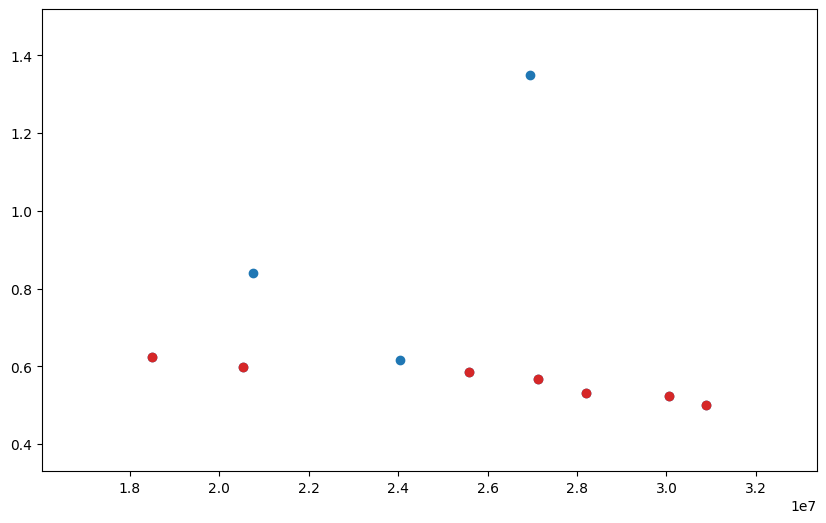

In [38]:
from typing import List


def pareto_front(times:List[int], energies:List[int]) -> (List[int], List[int]):
    #raise exception('Not implemented')
    # user code start

    points = sorted([(times[i], energies[i]) for i in range(len(times))], key=lambda x: (x[0], -x[1]))
    front = []

    for point in points:
        if not front or point[1] <= front[-1][1]:
            front.append(point)

    # user code end

    return zip(*front) # TODO remove
    return pareto_times, pareto_energies

def plot_pareto(tested_powercaps, times, energies):
    pareto_times, pareto_energies = pareto_front(times, energies)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot original data
    ax.scatter(energies, times, label='Test results', color='tab:blue')
    plt.scatter(pareto_energies, pareto_times, label='Test results in Pareto front', color='tab:red')
    ax.set_ylim([1.2 * min(times) - 0.2 * max(times), max(times) * 1.2 - min(times) * 0.2] )
    ax.set_xlim([1.2 * min(energies) - 0.2 * max(energies), max(energies) * 1.2 - min(energies) * 0.2] )


plot_pareto(tested_powercaps, times, energies)

To select the best settings for our needs we can use metrics. With a metric our problem of optimizing multiple variables is simplified to optimizing the value of the metric. Let's calculate our metrics for all the results.

For EDS and EDD metrics, instead of choosing $\alpha$ and $\beta$ we can choose one value - k - which is ineterpreted as the maximum multiplier of the possible time increase, and calculate the parameters with these formulas:

$\alpha = \frac{k-1}{k \times E_{init}}$
$\beta = \frac{1}{k \times t_{init}}$


In [39]:
edps = []
eds_values = []
edds = []
percent_diffs = []

initial_time, initial_energy = times[-1], energies[-1]
k_values = [1.5, 2]
alpha_values = [(k - 1) / (k * initial_energy) for k in k_values]
beta_values = [1 / (k * initial_time) for k in k_values]
eds_values = [[] for _ in k_values]
edds = [[] for _ in k_values]

for i in range(len(times)):
    time_result, energy_result = times[i], energies[i]
    edps.append(edp(energy_result, time_result))
    percent_diffs.append(percent_diff(energy_result, time_result, initial_energy, initial_time))
    for j, (alpha, beta) in enumerate(zip(alpha_values, beta_values)):
        eds_values[j].append(eds(energy_result, time_result, alpha, beta))
        edds[j].append(edd(energy_result, time_result, alpha, beta))


Plot'em all!

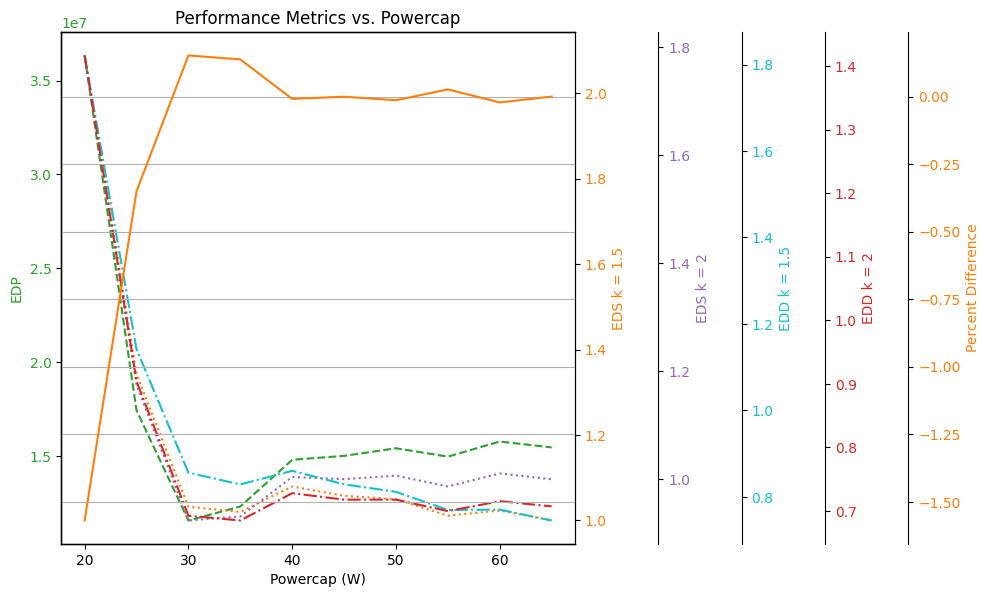

In [40]:
def plot_metrics(tested_powercaps, times, energies):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Powercap (W)')

    offset = 0
    colors = ['orange', 'purple', 'cyan', 'red', 'orange', 'brown', 'olive', 'pink', 'blue', 'grey']

    # EDP plot
    color = 'tab:green'
    ax1.set_ylabel('EDP', color=color)
    ax1.plot(tested_powercaps, edps, color=color, linestyle='--', label='EDP')
    ax1.tick_params(axis='y', labelcolor=color)

    # EDS plot
    for plot, k in zip(eds_values, k_values):
        ax4 = ax1.twinx()
        color = f'tab:{colors[offset // 60]}'
        ax4.spines['right'].set_position(('outward', offset))
        offset += 60
        ax4.set_ylabel(f'EDS k = {k}', color=color)
        ax4.plot(tested_powercaps, plot, color=color, linestyle=':', label='EDS')
        ax4.tick_params(axis='y', labelcolor=color)

    # EDD plot
    for plot, k in zip(edds, k_values):
        ax5 = ax1.twinx()
        color = f'tab:{colors[offset // 60]}'
        ax5.spines['right'].set_position(('outward', offset))
        offset += 60
        ax5.set_ylabel(f'EDD k = {k}', color=color)
        ax5.plot(tested_powercaps, plot, color=color, linestyle='-.', label='EDD')
        ax5.tick_params(axis='y', labelcolor=color)

    # Percent Difference plot
    ax6 = ax1.twinx()
    color = f'tab:{colors[offset // 60]}'
    ax6.spines['right'].set_position(('outward', offset))
    offset += 60
    ax6.set_ylabel('Percent Difference', color=color)
    ax6.plot(tested_powercaps, percent_diffs, color=color, linestyle='-', label='Percent Difference')
    ax6.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Performance Metrics vs. Powercap')
    plt.grid(True)
    plt.show()


plot_metrics(tested_powercaps, times, energies)

To understand the characteristics of different metrics it's helpful to see its isolines - the sets of all the points with the same value in a certain metric. In other words, all the points on the isoline are considered equally good by the metric. Analogously points below the isoline are considered better, and points above the isoline are considered worse by this metric. Let's make time-energy plot to see metrics isoline. The pareto-front is marked in red. Note that the optimal results selected by the different metrics are always in the Pareto front.

You should see that: 
- **EDP** is a horizontal line, but in fact it is a hyperbola with its center far out of the plot
- **EDS** and %diff are linear
- **EDD** is an ellipse

Isolines are plotted for the optimal points in the sense of each metric. When it intersects with the point, it means that it is the best result according to that metric.
To calculate the isolines we transformed the metrics to functions of time for Energy, assuming the value of the metric as the minimal value of this metrics for all the results.

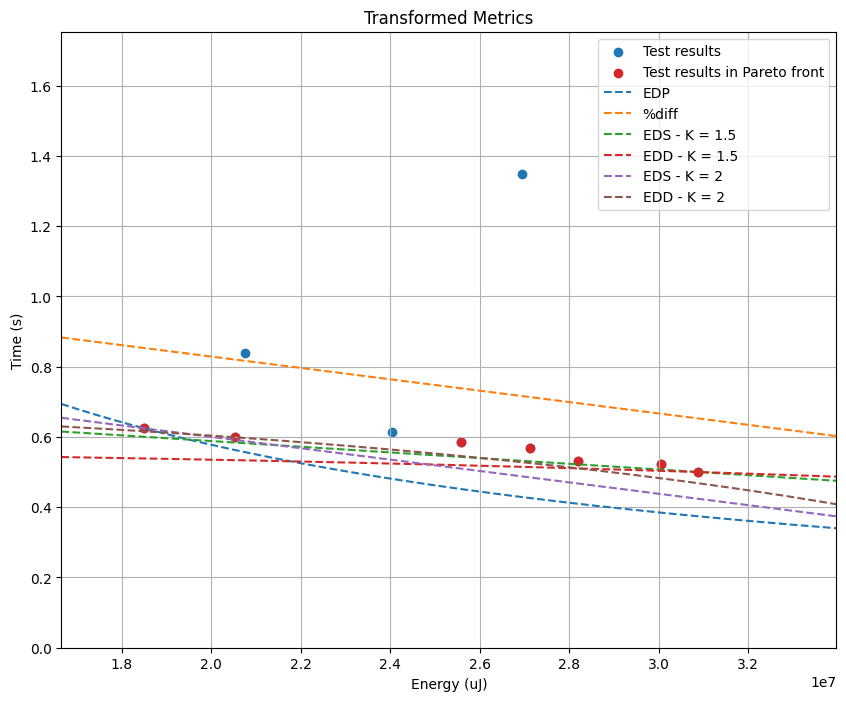

In [41]:
def trans_edp(E):
    c = min([edp(e, t) for e, t in zip(energies, times)])
    return c/E

def f_trans_eds(index):

    def trans_eds(E):
        alpha = alpha_values[index]
        beta = beta_values[index]
        c = min([eds(e, t, alpha, beta) for e, t in zip(energies, times)])
        return -alpha/beta * E + c/beta

    return trans_eds;

def f_trans_edd(index):

    def trans_edd(E):
        alpha = alpha_values[index]
        beta = beta_values[index]
        c = min([edd(e, t, alpha, beta) for e, t in zip(energies, times)])
        d = c**2 - (alpha*E)**2
        if d < 0:
            return None
        return np.sqrt(d)/beta

    return trans_edd;

def trans_percent_diff(E):
    c = max([percent_diff(e, t, initial_energy, initial_time) for e, t in zip(energies, times)])
    return c + (initial_energy - E)/initial_energy * initial_time + initial_time


def plot_isolines(tested_powercaps, times, energies):
    transformed_metrics = \
    {
        "EDP": trans_edp,
        "%diff": trans_percent_diff
    }

    for i, k in enumerate(k_values):
        transformed_metrics[f"EDS - K = {k}"] = f_trans_eds(i)
        transformed_metrics[f"EDD - K = {k}"] = f_trans_edd(i)

    # Plotting

    pareto_times, pareto_energies = pareto_front(times, energies)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot original data
    ax.scatter(energies, times, label='Test results', color='tab:blue')
    plt.scatter(pareto_energies, pareto_times, label='Test results in Pareto front', color='tab:red')
    ax.set_ylim([0, max(times) * 1.3] )
    ax.set_xlim([0.9 * min(energies), max(energies) * 1.1] )

    # Plot transformed metrics
    for label, metric_func in transformed_metrics.items():
        energy_range = np.linspace(0.9 * min(energies), max(energies) * 1.1, 20000)
        time_range = [metric_func(energy) for energy in energy_range]
        ax.plot(energy_range, time_range, label=label, linestyle="--")

    ax.set_xlabel('Energy (uJ)')
    ax.set_ylabel('Time (s)')
    ax.set_title('Transformed Metrics')
    ax.legend()

    ax.figure.set_figheight(8)
    plt.grid(True)
    plt.show()

plot_isolines(tested_powercaps, times, energies)

In [ ]:
Let's compare with our results

17 17 17


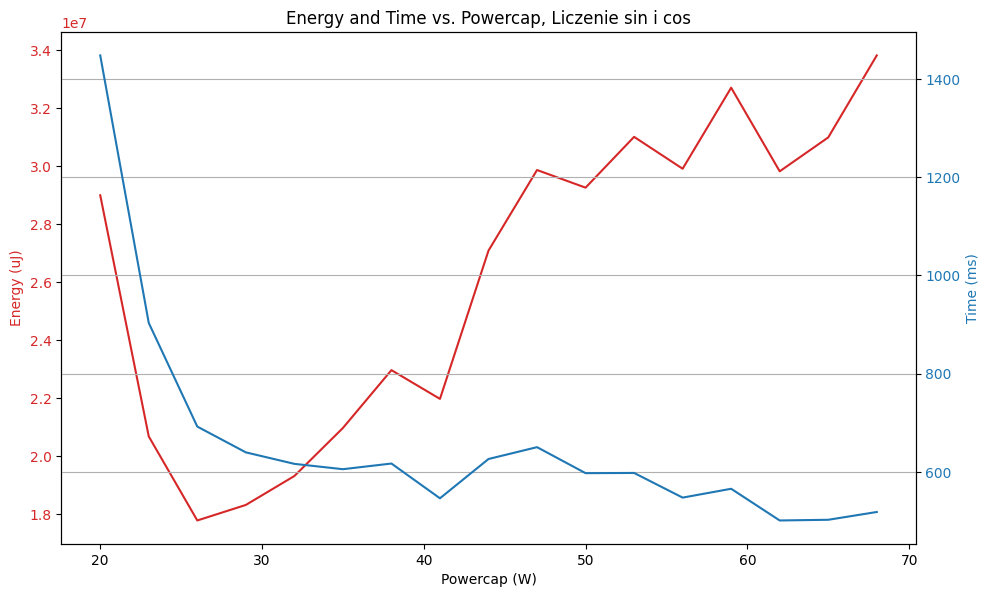

ValueError: x and y must have same first dimension, but have shapes (17,) and (10,)

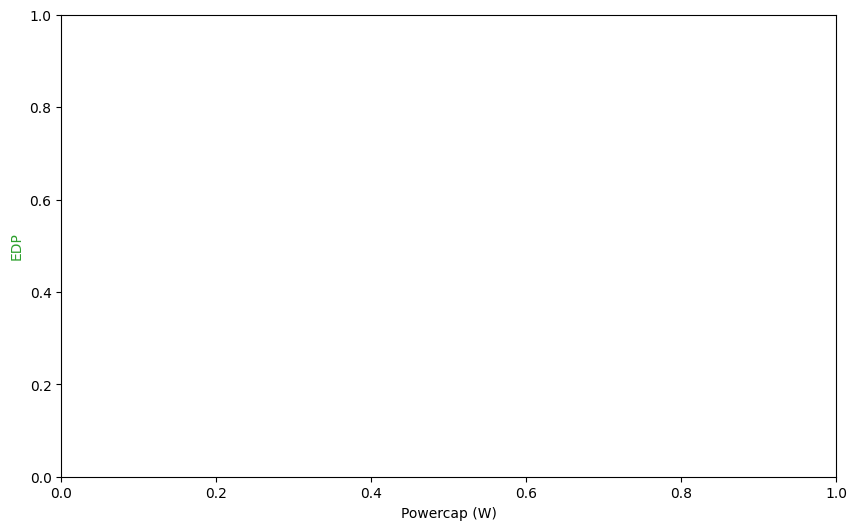

In [46]:
energies = [28987560.0, 20671285.0, 17772867.2, 18308375.8, 19305822.2, 20961652.8, 22956923.6, 21965556.6, 27079227.8, 29858041.2, 29250083.6, 31001458.8, 29902499.0, 32696705.8, 29813473.6, 30982001.0, 33810069.8] 
times = [1448.0544090270996, 903.2883644104004, 692.2488689422607, 639.7526264190674, 616.3496971130371, 605.4692268371582, 617.0114040374756, 546.2283611297607, 626.2267589569092, 650.347375869751, 597.4204540252686, 597.8137016296387, 547.6146221160889, 565.6117916107178, 501.063871383667, 502.4635314941406, 518.317174911499]
tested_powercaps = [i for i in range(20, 70, 3)]

print(len(energies), len(times), len(tested_powercaps))

plot_results_vs_powercap(tested_powercaps, times, energies)
plot_metrics(tested_powercaps, times, energies)
plot_isolines(tested_powercaps, times, energies)
